In [1]:
#Import modules
import pandas as pd
import spacy
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [5]:
#specify variables needed by functions
sp = spacy.load("en_core_web_sm")
stopwords = sp.Defaults.stop_words

#Functions
def text_prep(text):
    '''
    Inputs: string
    Outputs: string
    Description: Prepares raw text string for further NLP.
    '''
    #Convert to lowercase
    text = text.lower()
    #Tokenize
    text = sp(text)
    #Lemmatize
    text = [token.lemma_ for token in text]
    #Remove stop words
    text = " ".join([word for word in text if word not in stopwords])
    return text

def cumulatively_categorise(column, threshold = 0.75):
    '''
    Inputs: pandas series
    Outputs: pandas series, list
    Description: Reduces cardinality in categorical data by renaming the 25% least frequent categories to 'Other'
    '''
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value = int(threshold * len(column))
    #Initialise an empty list for our new minimised categories
    categories_list = []
    #Initialise a variable to calculate the sum of frequencies
    s = 0
    #Create a counter dictionary with key:value as unique_category:frequency
    counts = Counter(column)
    #Loop through the categories and corresponding frequencies after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s += dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value
        if s >= threshold_value:
            break
    #Append 'Other' category to the list
    categories_list.append('Other')
    #Replace all instances not in categories_list with 'Other'  
    new_column = column.apply(lambda x: x if x in categories_list else 'Other')
    #Return transformed column and list of categories
    return new_column, categories_list

In [3]:
#Data cleaning. Data has previously been checked and has no nulls.
#Read the data.
df = pd.read_csv("government-procurement-via-gebiz.csv")
df

,tender_no.,tender_description,agency,award_date,tender_detail_status,supplier_name,awarded_amt
0,ACR000ETT14000007,Provision Of Event Management And Related Serv...,Accounting And Corporate Regulatory Authority,6/2/2015,Awarded to No Suppliers,Unknown,0.00
1,ACR000ETT14000008,Invitation To Tender For The Provision Of Alte...,Accounting And Corporate Regulatory Authority,30/4/2015,Awarded to No Suppliers,Unknown,0.00
2,ACR000ETT14000009,Invitation To Tender For The Provision Of Manp...,Accounting And Corporate Regulatory Authority,28/1/2015,Awarded to Suppliers,RMA CONTRACTS PTE. LTD.,76071.21
3,ACR000ETT15000004,Invitation To Tender For The Provision Of Manp...,Accounting And Corporate Regulatory Authority,1/7/2015,Awarded to Suppliers,TESCOM (SINGAPORE) SOFTWARE SYSTEMS TESTING PT...,84000.00
4,ACR000ETT15000005,Proposed Interior Fitting Out Works for ACRA's...,Accounting And Corporate Regulatory Authority,24/4/2015,Awarded to Suppliers,MKS GLOBAL PTE. LTD.,653255.00
...,...,...,...,...,...,...,...
32751,WSG000ETT20300008,PROVISION OF INTEGRATED FACILITIES MANAGEMENT ...,Workforce Singapore,9/12/2020,Awarded to Suppliers,GUTHRIE FMC PTE. LTD.,4269564.00
32752,WSG000ETT20300010,INVITATION TO TENDER FOR RENEWAL OF SOFTWARE M...,Workforce Singapore,10/12/2020,Awarded to Suppliers,SQLNET PTE. LTD.,534800.00
32753,WSG000ETT20300011,SGUnited Jobs and Skills Placement Partners,Workforce Singapore,5/3/2021,Awarded to Suppliers,ADECCO PERSONNEL PTE LTD,1550.00
32754,WSG000ETT20300012,JOB EVALUATION EXERCISE AND COMPENSATION REVIEW,Workforce Singapore,5/2/2021,Awarded to Suppliers,CARROTS CONSULTING PTE LTD,70000.00


In [4]:
#Check data types in columns
df.dtypes

tender_no.               object
tender_description       object
agency                   object
award_date               object
tender_detail_status     object
supplier_name            object
awarded_amt             float64
dtype: object

In [4]:
#Clean each column one at a time.
#Drop "tender_no." column, use index provided by pandas.
df.drop(columns="tender_no.",inplace=True)

In [6]:
# Prepare tender_description data for NLP
df["tender_description"] = df["tender_description"].apply(lambda x: text_prep(x))

In [7]:
#Check cardinality for "agency" column
df["agency"].value_counts()

Housing and Development Board                        2223
Public Utilities Board                               2120
People's Association                                 1534
Agency for Science, Technology and Research          1493
Ministry of Home Affairs-Ministry Headquarter        1396
                                                     ... 
Centre for Public Project Management                    3
Ministry of Sustainability and the Environment          3
Home Team Science and Technology Agency                 2
Cabinet Office                                          1
Ministry of Home Affairs - Ministry Headquarter 1       1
Name: agency, Length: 122, dtype: int64

<AxesSubplot:>

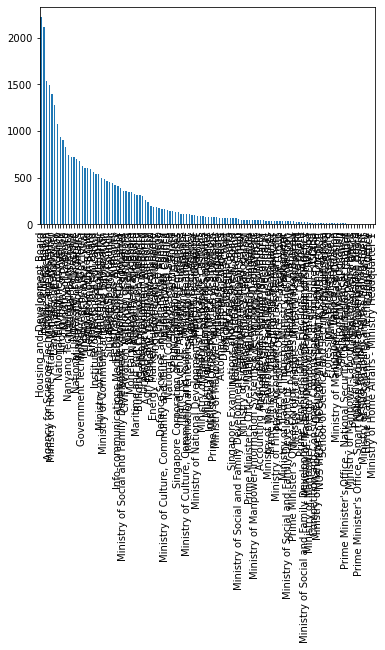

In [8]:
#Check distribution of "agency" column
df["agency"].value_counts().plot(kind="bar")

In [7]:
#Reduce the 122 different categories by calling the function with a default threshold of 75%
df["agency"], new_category_list = cumulatively_categorise(df['agency'])

In [10]:
#Check cardinality and distribution of "agency" column again, 30 instead of 122 categories
df["agency"].value_counts()

Other                                              8174
Housing and Development Board                      2223
Public Utilities Board                             2120
People's Association                               1534
Agency for Science, Technology and Research        1493
Ministry of Home Affairs-Ministry Headquarter      1396
Land Transport Authority                           1279
Ministry of Education                              1077
National Environment Agency                         941
Jurong Town Corporation                             904
Ministry of Defence                                 833
Nanyang Technological University                    738
National Parks Board                                722
Ngee Ann Polytechnic                                722
National University of Singapore                    705
Ministry of Foreign Affairs                         676
Government Technology Agency (GovTech)              620
Ministry of Finance - Vital                     

<AxesSubplot:>

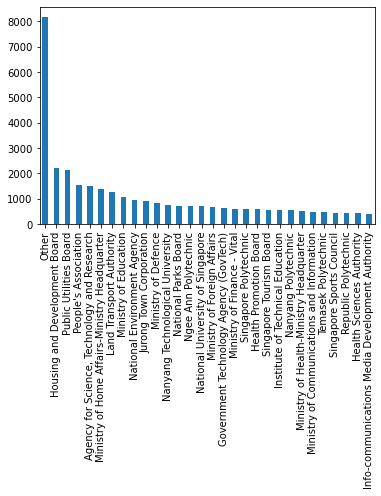

In [11]:
df["agency"].value_counts().plot(kind="bar")

In [8]:
#Perform one hot encoding and remove "agency" column
one_hot = pd.get_dummies(df["agency"])
df.drop(columns = "agency", inplace = True)
df = df.join(one_hot)

In [9]:
#Reorganize "award_date" column as yyyymmdd
date_new_format = [i for i in df["award_date"]]
date_new_format = [i.split('/') for i in date_new_format]
for i in date_new_format:
    if len(i[1]) == 1:
        i[1] = '0' + i[1]
    if len(i[0]) == 1:
        i[0] = '0' + i[0]
for i in date_new_format:
    i[0],i[2] = i[2],i[0]
date_new_format = [int(''.join(i)) for i in date_new_format]
df["award_date"] = date_new_format

In [14]:
#Check tender_detail_status column
df["tender_detail_status"].value_counts()

Awarded to Suppliers       26257
Awarded by Items            5085
Awarded to No Suppliers     1414
Name: tender_detail_status, dtype: int64

In [10]:
#Change tender_detail_status column results to 0, 1, or 2
df["tender_detail_status"].replace(\
    to_replace = ['Awarded to No Suppliers', 'Awarded to Suppliers', 'Awarded by Items'],\
    value = [0,1,2],\
    inplace = True)

<AxesSubplot:>

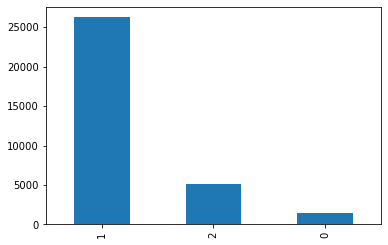

In [22]:
df["tender_detail_status"].value_counts().plot(kind = "bar")

In [11]:
#Remove supplier_name column. When predicting an ongoing tender, this data will not be available.
#Does not make sense to train the model with data from this column.
df.drop(columns = "supplier_name", inplace = True)

In [17]:
#Save cleaned data to csv
df.to_csv("gebiz_cleaned.txt", index = False)

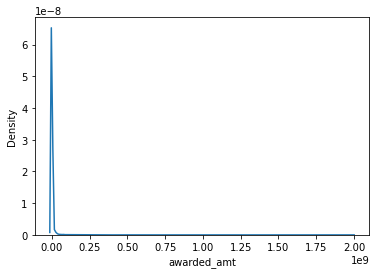

In [18]:
#Look at the distribution of dependent variable, "awarded_amt" column.
sns.kdeplot(df['awarded_amt'])
plt.show()

In [19]:
df["awarded_amt"].describe()

count    3.275600e+04
mean     3.942861e+06
std      3.415095e+07
min      0.000000e+00
25%      1.800075e+04
50%      1.649915e+05
75%      7.047750e+05
max      1.988000e+09
Name: awarded_amt, dtype: float64

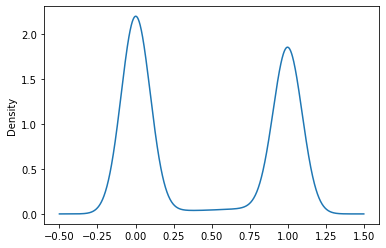

In [20]:
#Wide range of values spanning several orders of magnitude. Try breaking down this further.
working_df = df["awarded_amt"].loc[(df['awarded_amt'] >= 0) & (df['awarded_amt'] <= 1)]
working_df.plot.density()
plt.show()

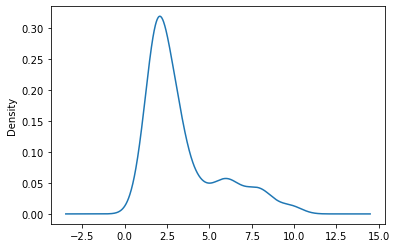

In [21]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 1) & (df['awarded_amt'] <= 10)]
working_df.plot.density()
plt.show()

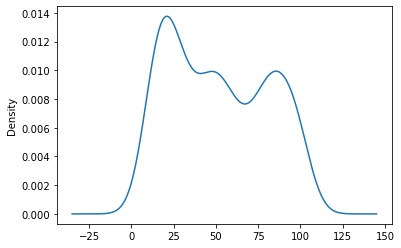

In [22]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 10) & (df['awarded_amt'] <= 100)]
working_df.plot.density()
plt.show()

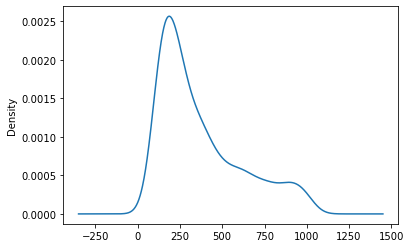

In [23]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 100) & (df['awarded_amt'] <= 1000)]
working_df.plot.density()
plt.show()

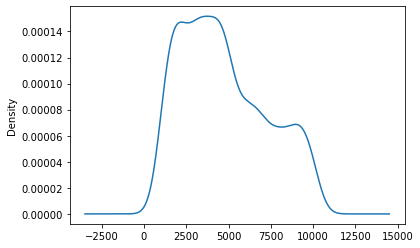

In [24]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 1000) & (df['awarded_amt'] <= 10000)]
working_df.plot.density()
plt.show()

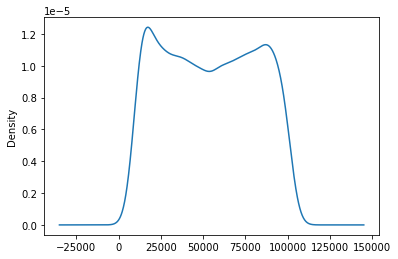

In [25]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 10000) & (df['awarded_amt'] <= 100000)]
working_df.plot.density()
plt.show()

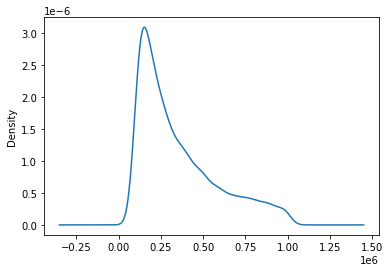

In [26]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 100000) & (df['awarded_amt'] <= 1000000)]
working_df.plot.density()
plt.show()

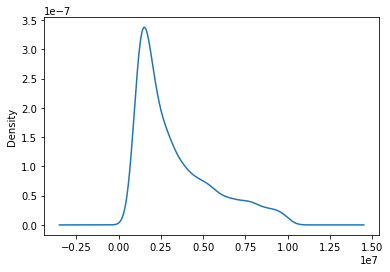

In [27]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 1000000) & (df['awarded_amt'] <= 10000000)]
working_df.plot.density()
plt.show()

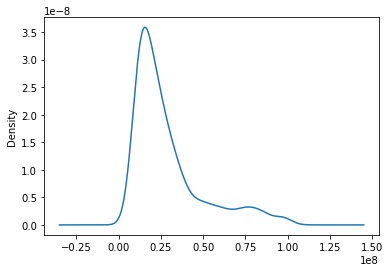

In [28]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 10000000) & (df['awarded_amt'] <= 100000000)]
working_df.plot.density()
plt.show()

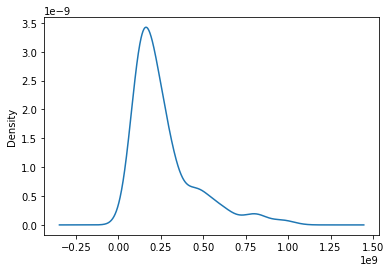

In [29]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 100000000) & (df['awarded_amt'] <= 1000000000)]
working_df.plot.density()
plt.show()

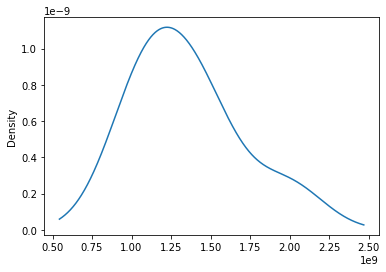

In [30]:
working_df = df["awarded_amt"].loc[(df['awarded_amt'] > 1000000000) & (df['awarded_amt'] <= 10000000000)]
working_df.plot.density()
plt.show()

In [12]:
#The larger the value, the less represented it becomes. These outliers have a high likelihood of throwing off the model.
#Distribution is uneven within each log range.
ranges = [-1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
df["awarded_amt"].groupby(pd.cut(df.awarded_amt, ranges)).count()

awarded_amt
(-1, 1]                       3640
(1, 10]                        459
(10, 100]                      447
(100, 1000]                   1061
(1000, 10000]                 1842
(10000, 100000]               5893
(100000, 1000000]            12592
(1000000, 10000000]           5278
(10000000, 100000000]         1311
(100000000, 1000000000]        226
(1000000000, 10000000000]        7
Name: awarded_amt, dtype: int64

<AxesSubplot:xlabel='awarded_amt'>

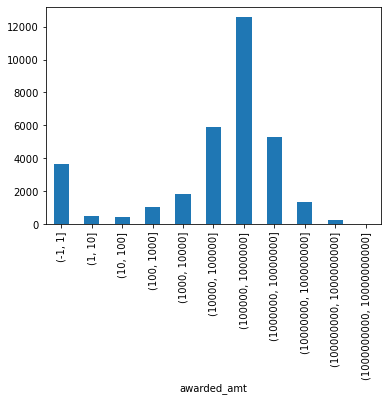

In [13]:
#Same data above plotted
df["awarded_amt"].groupby(pd.cut(df.awarded_amt, ranges)).count().plot(kind = "bar")

In [14]:
#Bin by these ranges then split into train and test using these bins.
df["bin"] = pd.cut(df.awarded_amt,ranges,labels = list(range(11)))
#pd.cut lower bound is not inclusive, ranges starts at -1 to include 0 values. Check for nulls.
df["bin"].isnull().value_counts()

False    32756
Name: bin, dtype: int64

In [25]:
#Split the data into train and test sets.
features = [c for c in df.columns if c != "awarded_amt" and c != "bin"]
X = df[features]
y = df["awarded_amt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df["bin"], random_state = 42)

In [34]:
#Create basic text-NLP features
X_train_tnlp = X_train.copy()
X_test_tnlp = X_test.copy()
X_list = [X_train_tnlp, X_test_tnlp]
for i in X_list:
    i['char_count'] = i['tender_description'].apply(len)
    i['word_count'] = i['tender_description'].apply(lambda x: len(x.split()))
    i['word_density'] = i['char_count'] / (i['word_count'] + 1)
    nlp = spacy.load('en_core_web_sm')
    adj_count = []
    adv_count = []
    noun_count = []
    num_count = []
    pron_count = []
    propn_count = []
    verb_count = []
    for index,row in i.iterrows():
        doc = nlp(str(row['tender_description']))
        pos_list = [n.pos_ for n in doc]
        count = Counter(pos_list)
        adj_count.append(count['ADJ'])
        adv_count.append(count['ADV'])
        noun_count.append(count['NOUN'])
        num_count.append(count['NUM'])
        pron_count.append(count['PRON'])
        propn_count.append(count['PROPN'])
        verb_count.append(count['VERB'])
    i['adj_count'] = adj_count
    i['adv_count'] = adv_count
    i['noun_count'] = noun_count
    i['num_count'] = num_count
    i['pron_count'] = pron_count
    i['propn_count'] = propn_count
    i['verb_count'] = verb_count
X_train_tnlp.drop(columns = 'tender_description', inplace = True)
X_test_tnlp.drop(columns = 'tender_description', inplace = True)

In [26]:
# Setup Count Vector features
count_vect = CountVectorizer(token_pattern = r'\w{1,}')
count_vect.fit(df['tender_description'])
X_train_count = count_vect.transform(X_train['tender_description'])
X_test_count = count_vect.transform(X_test['tender_description'])

In [27]:
X_train_count.shape

(24567, 14775)

In [16]:
#Setup TF-IDF

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(df['tender_description'])
X_train_tfidf = tfidf_vect.transform(X_train['tender_description'])
X_test_tfidf  = tfidf_vect.transform(X_test['tender_description'])


# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(df['tender_description'])
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train['tender_description'])
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test['tender_description'])


# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(df['tender_description'])
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train['tender_description'])
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test['tender_description'])

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')


C:\Users\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:546: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [ ]:
#Do not run this, tested runtime is >24h on dual core Intel(R) Core(TM) i5-8400 CPU @ 2.80GHz 2.81 GHz.
#Program did not finish character level tf-idf ngrams.
#Scores presented are R-squared values based on model used.

parameters = {
    'n_estimators' : [10,100,500],
    'max_depth' : [10,100,500],
    'random_state' : [42]
}
train_list = [X_train_tnlp,X_train_count,X_train_tfidf,X_train_tfidf_ngram,X_train_tfidf_ngram_chars]
test_list = [X_test_tnlp,X_test_count,X_test_tfidf,X_test_tfidf_ngram,X_test_tfidf_ngram_chars]
rfr = RandomForestRegressor()
gcv = GridSearchCV(rfr, parameters)
for i in range(5):
    gcv.fit(train_list[i],y_train)
    print(i)
    print(gcv.best_estimator_)
    print(gcv.best_score_)
    print(gcv.score(test_list[i],y_test))

0
RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42)
0.0404912479935909
-0.2472130338816414
1
RandomForestRegressor(max_depth=10, random_state=42)
0.22911205964762998
0.19432479946053605
2
RandomForestRegressor(max_depth=500, random_state=42)
0.2104839721555903
0.239499318575784
3
RandomForestRegressor(max_depth=500, random_state=42)
0.1872448020517444
0.09101759950848232


In [38]:
#Based on calculation of R-squared, baseline would have a score of zero.
#Formula for calculating R-squared of baseline model, assuming every prediction of target variable is its mean.

r_squared = 1 - (sum(y - y.mean())) / (sum(y - y.mean()))
r_squared

0.0

In [17]:
#ngram-based tfidf seemed to give the best result, implying some relationship between X and y.
#Save these as a new dataset and try some other models on it.
X_train_tfidf_ngram = pd.DataFrame(X_train_tfidf_ngram.todense())
X_test_tfidf_ngram = pd.DataFrame(X_test_tfidf_ngram.todense())
X_train_tfidf_ngram.to_csv("gebiz_X_train.txt", index = False)
X_test_tfidf_ngram.to_csv("gebiz_X_test.txt", index = False)
y_train.to_csv("gebiz_y_train.txt", index = False)
y_test.to_csv("gebiz_y_test.txt", index = False)

In [18]:
#Had an idea to compare existing Random Forest Regression model to Linear Regression model
X_train = pd.read_csv("gebiz_X_train.txt")
X_test = pd.read_csv("gebiz_X_test.txt")
y_train = pd.read_csv("gebiz_y_train.txt")
y_test = pd.read_csv("gebiz_y_test.txt")

In [21]:
#Fit and evaluate
lr = LinearRegression()
lr.fit(X_train,y_train)
print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

0.3341293267473907
-1.794511004804252e+24
